In [24]:
from setup_cc import *
from sklearn.preprocessing import StandardScaler
from hembedder.utils.hyperparameter_tuning_legacy import grid_search, random_search
from hembedder.utils import quality_metrics
from hembedder.utils.hyperparameter_tuning import Hyperparameter_tuning
import umap
from sklearn.decomposition import PCA
import pacmap
import trimap
#import phate
#n_n 5
evaluate_dcor_2_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, metric='manhattan')
ascending = [False,False, False, False,False]
evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1,metric='manhattan', n_neighbours=15)
evaluators = {'Random_triplets' : evaluate.random_triplet_eval,
                    'dcor_1': evaluate._return_distance_correlation,
                    'neighbor_kept_ratio_15' : evaluate.neighbor_kept_ratio_eval,
                    'dcor_2': evaluate_dcor_2_default._return_distance_correlation,
                    'Trustworthiness': evaluate._return_trustworthiness}



## PCA comparison
### With scaler

In [ ]:

pca_param = {'n_components': [2,4,6,8,10,20,30],
            "whiten": [False,True]}
tuning = Hyperparameter_tuning(cell_dyn,PCA,evaluators=evaluators,param_grid=pca_param,
                        ascending=ascending, file_name="models/embedding/PCA/cell_dyn_tuning_PCA_40000_MF100_n_components.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10)
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/PCA/cell_dyn_tuning_PCA_40000_MF100_n_components.csv")



Total number of embedding runs :  14 (combos)x10(iterations) with [30000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


14it [2:00:16, 515.47s/it]                        

Hyperpameter tuning is done and the best scores with 30000 sample size are
Random_triplets           0.975512
dcor_1                    0.998489
neighbor_kept_ratio_30    0.807378
dcor_2                    0.911656
Trustworthiness            0.99639
Name: 0, dtype: object
with parameter: {'n_components': 30, 'whiten': False}
Finish tuning in  120.28 minutes.


## PacMap

In [7]:
pacmap_param = {'n_components': [2,4,6,8,10,20,30]}
tuning = Hyperparameter_tuning(cell_dyn,pacmap.PaCMAP,evaluators=evaluators,param_grid=pacmap_param,
                        ascending=ascending, file_name="models/embedding/pacmap/cell_dyn_tuning_pacmap_40000_MF100_n_components.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10)
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/pacmap/cell_dyn_tuning_pacmap_40000_MF100_n_components.csv")

Total number of embedding runs :  7 (combos)x10(iterations) with [30000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


7it [1:47:22, 920.42s/it]                       

Hyperpameter tuning is done and the best scores with 30000 sample size are
Random_triplets           0.751532
dcor_1                    0.815474
neighbor_kept_ratio_30    0.119115
dcor_2                    0.677716
Trustworthiness            0.84922
Name: 0, dtype: object
with parameter: {'n_components': 2}
Finish tuning in  107.38 minutes.


## TriMap

In [2]:

trimap_param = {'n_dims': [2,4,6,8,10,20,30],
                'n_inliers' : [5,15,30,50,100]}
tuning = Hyperparameter_tuning(cell_dyn,trimap.TRIMAP,evaluators=evaluators,param_grid=trimap_param,
                        ascending=ascending, file_name="models/embedding/trimap/cell_dyn_tuning_trimap_40000_MF100_n_components_n_inliers.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10, distance = 'manhattan')
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/trimap/cell_dyn_tuning_trimap_40000_MF100_n_components_n_inliers.csv")

Total number of embedding runs :  35 (combos)x10(iterations) with [40000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


35it [30:25:09, 3128.85s/it]                           

Hyperpameter tuning is done and the best scores with 40000 sample size are
Random_triplets           0.782312
dcor_1                    0.900346
neighbor_kept_ratio_30    0.147319
dcor_2                    0.811135
Trustworthiness           0.960437
Name: 0, dtype: object
with parameter: {'n_dims': 6, 'n_inliers': 100, 'distance': 'manhattan'}
Finish tuning in  1825.16 minutes.


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
embedder_full = umap.UMAP(n_components=6,n_neighbors=15,metric = 'manhattan', output_metric= 'manhattan',
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=0.1, dens_frac=0.1, 
                        repulsion_strength=1.1, negative_sample_rate=10, random_state=42, min_dist=0.0)


le_pipe = Pipeline([('scaler', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(cell_dyn.to_numpy(dtype = np.float32))


Pipeline(steps=[('scaler', StandardScaler()),
                ('embedder',
                 UMAP(dens_frac=0.1, dens_lambda=0.1, metric='manhattan', min_dist=0.0, n_components=8, n_epochs=500, n_jobs=4, negative_sample_rate=10, output_metric='manhattan', random_state=42, repulsion_strength=1.1, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

In [5]:
embedded = pd.DataFrame(le_pipe.named_steps['embedder'].embedding_, columns = ["dim_1","dim_2","dim_3","dim_4","dim_5","dim_6","dim_7","dim_8"])
embedded.to_csv("data/cell_dyn_UMAP_embedded_dim_8_MF100.csv")

In [10]:
embedded['sex'] = cell_dyn_with_labels.gender
embedded['age'] = cell_dyn_with_labels.age
embedded['study_id'] = cell_dyn_with_labels.studyid_alle_celldyn
embedded['analysis_dt'] = cell_dyn_with_labels.asp_dt
embedded['sample_dt'] = cell_dyn_with_labels.afname_dt
embedded['draw_hour'] = cell_dyn_with_labels.draw_hour

In [23]:
embedded.to_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/cell_dyn_UMAP_embedded_dim_8_MF100.feather")

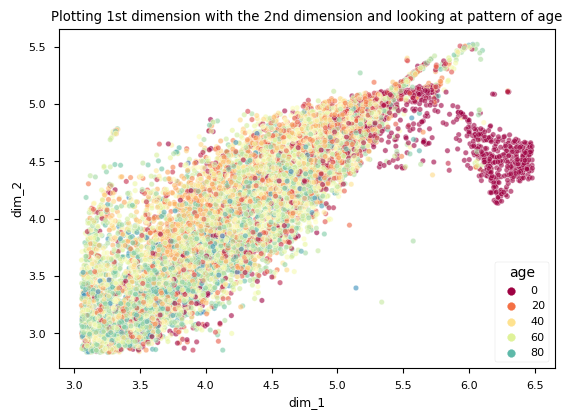

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
if True:
    plt.style.use("seaborn-paper")

    d1q01 = embedded.dim_1.quantile(0.01)
    d1q99 = embedded.dim_1.quantile(0.99)
    d2q01 = embedded.dim_2.quantile(0.01)
    d2q99 = embedded.dim_2.quantile(0.99)

    conds = (embedded.dim_1>d1q01) & (embedded.dim_1<d1q99) & (embedded.dim_2>d2q01) & (embedded.dim_2<d2q99)

    plot_df = embedded.loc[conds].sample(min([10000, sum(conds)]))

    #fig, ax = plt.subplots(12,3,figsize = (30,50))
    #i,j = 0,0

    sns.scatterplot(data=plot_df, x='dim_1', y='dim_2',  hue='age', palette="Spectral", s=15, alpha=0.6).set_title("Plotting 1st dimension with the 2nd dimension and looking at pattern of age")
                            #s = 15, alpha = 0.05, palette="Spectral")
    #sns.color_palette("vlag", as_cmap=True) # icefire, Spectral
    #for colx in plot_df[[c for c in embedded if 'dim' in c]]:
        #for coly in plot_df[[c for c in embedded if 'dim' in c]]:
            #sns.scatterplot(data=plot_df, x=colx, y=coly,  hue='age',
                           # s = 15, alpha = 0.05, ax=ax[i,j], palette="Spectral")
            #i = i+1 if j == 2 else i
            #j = j+1 if j < 2 else 0
    #plt.show()
    #fig.suptitle(model_str)
    #plt.savefig("T:\laupodteam\AIOS\Chontira\CellDynClustering\presentations\images\\age_embedding.png", dpi=300)  